# Run Patch Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import geopandas as gpd
from tensorflow import keras
from tqdm.notebook import tqdm

from scripts.viz_tools import normalize, plot_image_grid
from scripts.dl_utils import download_patch, rect_from_point, pad_patch
from scripts import dl_utils

In [176]:
START_DATE = '2019-01-01'
END_DATE = '2020-02-01'
METHOD = 'min'
MOSAIC_PERIOD = 3  # the period over which to mosaic image data in months
SPECTROGRAM_INTERVAL = 2  # For spectrogram analysis, the time from the start of one mosaic to the start of the next,
 # in number of mosaic periods

In [177]:
def unit_norm(samples):
    means = [1367.8407, 1104.4116, 1026.8099, 856.1295, 1072.1476, 1880.3287, 2288.875, 2104.5999, 2508.7764, 305.3795, 1686.0194, 946.1319]
    deviations = [249.14418, 317.69983, 340.8048, 467.8019, 390.11594, 529.972, 699.90826, 680.56006, 798.34937, 108.10846, 651.8683, 568.5347]
    normalized_samples = np.zeros_like(samples).astype('float32')
    for i in range(0, 12):
        #normalize each channel to global unit norm
        normalized_samples[:,:,:,i] = (np.array(samples)[:,:,:,i] - means[i]) / deviations[i]
    return normalized_samples

def patch_classifier_predict(polygon, model):
    """
    Run a patch classifier on the polygon of interest.
    Outputs predictions and patches for each patch extracted.
    """
    
    mosaics, _ = dl_utils.download_mosaics(polygon, START_DATE, END_DATE, MOSAIC_PERIOD, method=METHOD)
    new_pairs = dl_utils.pair(mosaics, SPECTROGRAM_INTERVAL)
    pairs = [p for p in new_pairs if dl_utils.masks_match(p)]
    
    preds = []
    for pair in pairs:
        normed = unit_norm(pair)
        model_input = np.zeros((28,28,24))
        model_input[:,:,:12] = dl_utils.pad_patch(normed[0], 28)
        model_input[:,:,12:] = dl_utils.pad_patch(normed[1], 28)
        pred = model.predict(np.expand_dims(model_input, axis=0))[0][1]
        preds.append(pred)
    if len(preds) == 0:
        print("No cloud free patches extracted. Try expanding your data time period.")
    
    return preds, pairs

In [178]:
output_dir = '../data/model_outputs/candidate_sites/0.0.7/patches_v0.1'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Load Model

In [179]:
model = keras.models.load_model('../models/v0.1_weak_labels_28x28x24.h5', 
                                custom_objects={'LeakyReLU': keras.layers.LeakyReLU,
                                                'ELU': keras.layers.ELU,
                                                'ReLU': keras.layers.ReLU
                                               })
input_height = model.input_shape[1]
# Get model input size in degrees
rect_height = ((input_height + 4) / 100) / 111.1

## Download Candidate Site Patches

In [180]:
# Load coordinates from the detect_candidates output
filename = 'sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_blobs_thresh_0.8_min-sigma_5_area-thresh_0.0025'

candidate_sites = gpd.read_file('../data/model_outputs/candidate_sites/0.0.7/' + filename + '.geojson')
candidate_sites['rects'] = [rect_from_point([point.x, point.y], rect_height) for point in candidate_sites['geometry']]
print(len(candidate_sites), "candidate sites loaded")

2906 candidate sites loaded


## Run Network and Visualize Predictions

In [ ]:
patch_predictions = {}
for polygon, name in tqdm(zip(candidate_sites['rects'][1664:], candidate_sites['name'][1664:]), total=len(candidate_sites['rects'][1664:])):
    try:
        preds, patches = patch_classifier_predict(polygon, model)

        print(f"{name}, {preds}")
        patch_predictions[name] = {
            'preds': preds,
            'patches': patches,
        }
    except KeyboardInterrupt:
        print("Keyboard Interrupt!")
        break
    except Exception as e:
        print('Failure', name)
        print(e)
        patch_predictions[name] = {
            'preds': [],
            'patches': [],
        }

sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1665, [2.7004787e-06, 2.9512245e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1666, [2.4012234e-19]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1667, [0.0001575591, 2.9051975e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1668, [5.917383e-05, 3.0610404e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1669, [2.6520431e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1670, [6.818017e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1671, [0.8451721, 0.8354668]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1672, [4.66261e-08, 1.1227997e-12]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1673, [3.4877165e-10, 1.2681705e-08]
No cloud free patches extracted. Try expanding your data time period.
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1674, []
No cloud free patches extracted. Try expanding your data time period.
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1675, []
sumatra_v0.0.7_20

sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1764, [9.946445e-10, 4.3863025e-12]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1765, [1.2767971e-06, 3.681119e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1766, [4.5489414e-06, 9.71296e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1767, [4.404133e-16, 4.5630575e-17]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1768, [2.9307863e-13, 3.2735904e-13]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1769, [5.9076166e-09, 6.162089e-09]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1770, [9.395562e-09, 1.7006935e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1771, [2.8571966e-07, 2.6471172e-14]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1772, [3.0632367e-12, 4.9239303e-18]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1773, [0.4665818, 0.02881905]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1774, [3.1495754e-05, 0.002440404]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1775, [1.

sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1861, [0.00043902066, 0.00020052676]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1862, [1.5295706e-07, 6.854644e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1863, [3.1051793e-06, 2.5459535e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1864, [1.7512942e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1865, [3.6635124e-14, 8.8685666e-17]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1866, [0.0015082577, 1.0301179e-10]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1867, [3.5985354e-07, 2.3140617e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1868, [1.1589075e-06, 1.17356e-05]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1869, [7.21011e-06, 1.0116885e-09]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1870, [0.052516717, 0.3210079]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1871, [0.0001256961, 0.042153552]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1872, [6.0169704e-08, 6

sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1957, [1.0, 1.0]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1958, [0.4234454, 2.4425958e-10]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1959, [1.0319048e-15, 2.308786e-18]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1960, [3.691193e-12]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1961, [0.0011977028, 0.03055987]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1962, [5.147845e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1963, [0.00040299434]
No cloud free patches extracted. Try expanding your data time period.
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1964, []
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1965, [3.6356383e-07, 3.7822356e-10]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1966, [3.1182576e-10, 0.72516495]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1967, [8.093398e-05]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_1968, [5.503635e-10, 5.5969462e-08]
sumatra_v0

sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2052, [7.875099e-07, 5.1411484e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2053, [1.2271557e-06, 1.7435856e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2054, [6.657966e-13, 1.7755955e-13]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2055, [8.928592e-11, 1.1078873e-08]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2056, [0.00032957847]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2057, [8.033786e-08, 4.2123506e-11]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2058, [3.428012e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2059, [0.79098094, 5.6426614e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2060, [7.849196e-12, 2.4314042e-09]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2061, [3.3426804e-09, 7.890937e-13]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2062, [1.163532e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2063, [1.1431686e-06]
sumatra_v0.0.7_2019-01-01_2

sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2153, [2.8820511e-07, 3.5552016e-11]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2154, [1.0712159e-07]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2155, [0.9996629, 0.99935704]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2156, [1.7723165e-06]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2157, [2.717229e-19]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2158, [7.721664e-06, 1.0278549e-05]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2159, [3.6539324e-05, 8.972544e-05]
No cloud free patches extracted. Try expanding your data time period.
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2160, []
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2161, [0.006210038]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2162, [0.8333036, 0.20653982]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2163, [0.8795774, 0.0013946075]
sumatra_v0.0.7_2019-01-01_2021-06-01mosaic-median_2164, [0.00887278]
sumatra_v0.0.7_2

In [182]:
candidate_sites['mean'] = [-1 for _ in range(len(candidate_sites))]
candidate_sites['min'] = [-1 for _ in range(len(candidate_sites))]
candidate_sites['max'] = [-1 for _ in range(len(candidate_sites))]
candidate_sites['std'] = [-1 for _ in range(len(candidate_sites))]
candidate_sites['count'] = [-1 for _ in range(len(candidate_sites))]

In [183]:
for site in patch_predictions:
    index = np.argmax(candidate_sites['name'] == site)
    preds = patch_predictions[site]['preds']
    if len(preds) > 0:
        candidate_sites.loc[index, ('mean')] = round(np.mean(preds).astype(np.float), 6)
        candidate_sites.loc[index, ('min')] = round(np.min(preds).astype(np.float), 6)
        candidate_sites.loc[index, ('max')] = round(np.max(preds).astype(np.float), 6)
        candidate_sites.loc[index, ('std')] = round(np.std(preds).astype(np.float), 6)
        candidate_sites.loc[index, ('count')] = len(preds)

In [184]:
candidate_sites_export = candidate_sites.drop(['lon', 'lat', 'rects'], axis=1)

In [185]:
candidate_sites_export.to_file(os.path.join(output_dir, 'patch_' + filename + '.geojson'), driver='GeoJSON', index=False)

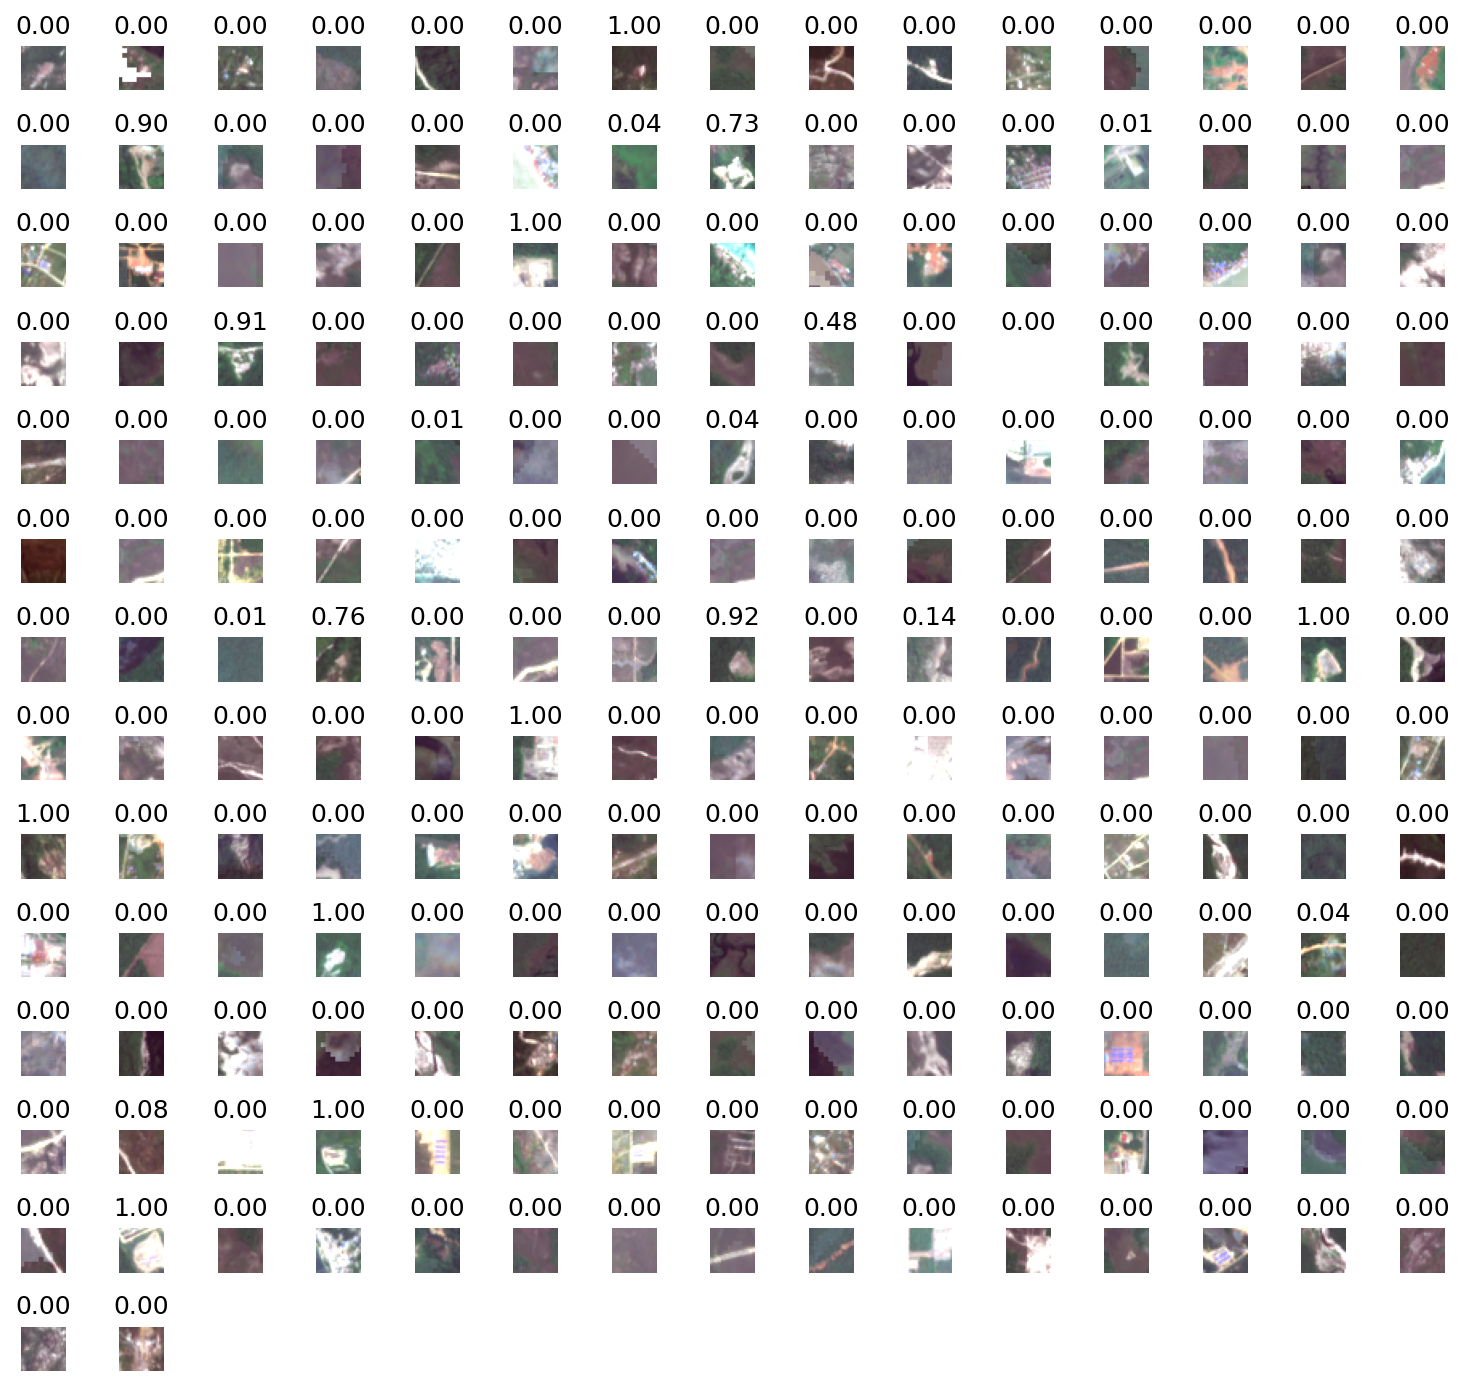

In [165]:
num_img = int(np.ceil(np.sqrt(len([np.mean(v['preds']) for v in patch_predictions.values() if len(v['preds']) > 0]))))
plt.figure(figsize=(10,10), dpi=150, facecolor=(1,1,1))

counter = 1
for v in patch_predictions.values():
    if len(v['preds']) > 0:
        plt.subplot(num_img, num_img, counter)
        plt.imshow(np.clip(dl_utils.pad_patch(unit_norm(v['patches'][0])[0,:,:,3:0:-1] / 4 + 0.5, 28), 0, 1))
        plt.axis('off')
        plt.title(f"{np.mean(v['preds']):.2f}")
        counter += 1
plt.tight_layout()
plt.show()

# Display map

In [140]:
threshold = 0.25
# Write only sites with predictions greater than a threshold, or with a value of -1 (no data)
filtered_candidate_sites = candidate_sites_export.query(f'mean > {threshold}')
print(f"{len(filtered_candidate_sites)} / {len(candidate_sites_export)} sites found above the threshold of {threshold}")
#filtered_candidate_sites.to_csv(f'../data/model_outputs/candidate_sites/{filename}_patch_clf_thresh_{threshold}.csv', index=False)

47 / 97 sites found above the threshold of 0.25


In [141]:
filtered_candidate_sites

,name,geometry,mean,std,min,max,count
2,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (119.83284 -3.06479),0.454836,0.140537,3.523327e-01,0.693409,4
3,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (123.58126 -5.34781),0.699140,0.142866,5.167472e-01,0.855201,4
4,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (119.93684 -0.91049),0.719519,0.222908,3.852124e-01,0.996445,4
8,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (121.51633 -4.72241),0.413166,0.193108,1.885589e-01,0.627997,4
9,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (120.81261 1.02491),0.702273,0.128604,5.050807e-01,0.844187,4
10,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (120.27299 -2.54236),0.468302,0.234924,2.860740e-01,0.869156,4
11,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (122.64646 -4.02825),0.267135,0.034579,2.325559e-01,0.301713,2
13,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (122.45509 0.57185),0.273120,0.171812,9.698506e-02,0.498061,4
15,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (125.94530 -1.98989),0.521598,0.316420,1.082345e-03,0.797204,4
16,sulawesi_v0.0.7_2019-01-01_2021-06-01mosaic-me...,POINT (122.39350 -4.75911),0.634854,0.369072,4.701152e-06,0.915978,4


In [132]:
kepler_config={
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "anqfulm",
          "type": "point",
          "config": {
            "dataId": "Candidate Sites",
            "label": "Point",
            "color": [
              221,
              178,
              124
            ],
            "columns": {
              "lat": "lat",
              "lng": "lon",
              "altitude": None
            },
            "isVisible": True,
            "visConfig": {
              "radius": 30,
              "fixedRadius": False,
              "opacity": 0.8,
              "outline": True,
              "thickness": 3,
              "strokeColor": None,
              "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "strokeColorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radiusRange": [
                0,
                50
              ],
              "filled": False
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantile",
            "strokeColorField": {
              "name": "mean",
              "type": "real"
            },
            "strokeColorScale": "quantile",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
      },
      "mapStyle":{
         "styleType":"satellite"
      }
   }
}

In [133]:
# Plot blob locations on a satellite base image
candidate_map = KeplerGl(height=800, config=kepler_config)
candidate_map.add_data(data=filtered_candidate_sites, name='Candidate Sites')
candidate_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'anqfulm', 'type': …

In [ ]:
positive_patches = [np.ma.median(patch_predictions[site]['patches'], axis=0) for site in filtered_candidate_sites['name']]
plot_image_grid(positive_patches, labels=[name.split('_')[-1] for name in filtered_candidate_sites['name']])